In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O daily-min-temperatures.csv

In [ ]:
import pandas as pd

data = pd.read_csv('/content/daily-min-temperatures.csv')
data.head(5)

series = np.asarray(data.iloc[:,1])
time = np.arange(len(temp))

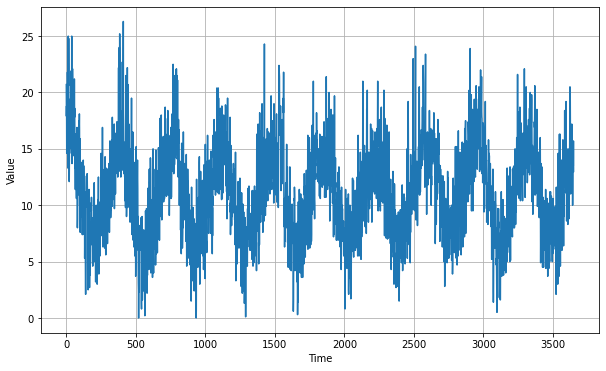

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def window_dataset(data,window_size,batch_size,shuffle_buffer_size):
  data = tf.expand_dims(data,axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(data)
  dataset = dataset.map( lambda x : tf.cast(x,tf.float32))
  dataset = dataset.window(size = window_size + 1, shift = 1, drop_remainder= True)
  dataset = dataset.flat_map(lambda x : x.batch(window_size+1))
  dataset = dataset.map(lambda x : (x[:-1],x[-1:]))
  dataset = dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(1)

  return dataset

x_data = window_dataset(x_train,window_size,batch_size,shuffle_buffer_size)
val_data = window_dataset(x_valid,window_size,batch_size,shuffle_buffer_size)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.Input(shape=(window_size,1)),

  tf.keras.layers.Conv1D(
      filters=32,
      kernel_size = 5,
      activation = 'relu',
      kernel_initializer = tf.keras.initializers.HeNormal()
  ),
  tf.keras.layers.LSTM(units = 32, return_sequences= True ),
  tf.keras.layers.LSTM(units = 32, return_sequences= False ),

  tf.keras.layers.Dense(units = 10, activation= 'relu',  kernel_initializer = tf.keras.initializers.HeNormal()),
  tf.keras.layers.Dense(units = 1, activation= 'linear'),

  tf.keras.layers.Lambda(lambda x : x * 10)
])

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10**(epoch/20)
)

#Finding the best learning rate
model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=5e-6, momentum=0.9),
    loss = tf.keras.losses.MSE,
    metrics = ['mae']
)

model.fit(
    x_data,
    epochs = 100,
    shuffle = True,
    verbose = 0,
    callbacks = [lr_schedule]
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


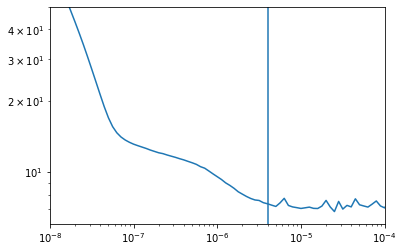

In [ ]:
lr = model.history.history['lr']
loss = model.history.history['loss']

plt.loglog(lr,loss);
#xmin,xmax,ymin,ymax
plt.axis([1e-8,1e-4,0,50])
plt.axvline(4e-6);

In [ ]:
#clean all internal variables from the previous training step
tf.keras.backend.clear_session()

#Finding the best learning rate
model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=4e-6, momentum=0.9),
    loss = tf.keras.losses.MSE,
    metrics = ['mae']
)

model.fit(
    x_data,
    validation_data = val_data,
    epochs = 500,
    shuffle = True,
    verbose = 1,
    callbacks = [
      tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',mode = 'min',patience = 10),
      tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=20,restore_best_weights=True)
    ]
)

Epoch 1/500
78/78 [==============================] - 4s 19ms/step - loss: 59.9550 - mae: 6.0663 - val_loss: 13.9413 - val_mae: 2.9883
Epoch 2/500
78/78 [==============================] - 1s 12ms/step - loss: 14.7475 - mae: 3.0121 - val_loss: 11.5519 - val_mae: 2.6802
Epoch 3/500
78/78 [==============================] - 1s 14ms/step - loss: 12.7873 - mae: 2.7933 - val_loss: 10.4882 - val_mae: 2.5370
Epoch 4/500
78/78 [==============================] - 1s 11ms/step - loss: 11.6704 - mae: 2.6453 - val_loss: 9.7511 - val_mae: 2.4259
Epoch 5/500
78/78 [==============================] - 1s 11ms/step - loss: 11.0785 - mae: 2.5548 - val_loss: 9.2063 - val_mae: 2.3479
Epoch 6/500
78/78 [==============================] - 1s 10ms/step - loss: 9.9653 - mae: 2.4492 - val_loss: 8.9276 - val_mae: 2.3069
Epoch 7/500
78/78 [==============================] - 1s 11ms/step - loss: 9.6773 - mae: 2.3957 - val_loss: 8.5251 - val_mae: 2.2517
Epoch 8/500
78/78 [==============================] - 1s 10ms/step - 

In [ ]:
def model_forecast(model, series, window_size):
  forecast = []
  for i in range( len(series)- window_size):
    prediction = model.predict(series[i:i+window_size][np.newaxis])[0][0]
    forecast.append(prediction)
  
  return forecast

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)

In [ ]:
#rnn_forecast
rnn = np.asarray(rnn_forecast)[split_time - window_size:]
rnn.shape,x_valid.shape

((1150,), (1150,))

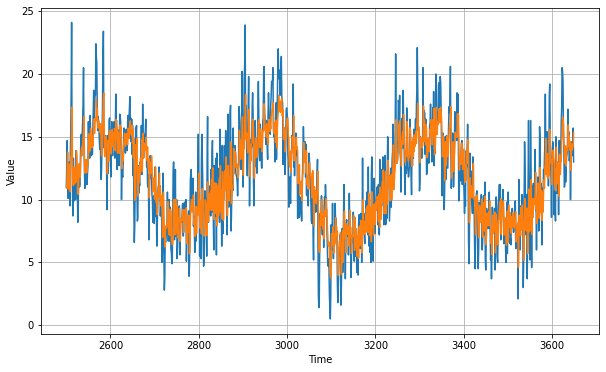

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7793293

In [ ]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[15.912018, 16.038736, 15.914212, 17.475159, 18.253199, 17.35749, 16.335619, 16.652714, 15.786056, 16.807362, 19.244595, 15.257939, 13.763044, 14.868613, 16.23176, 17.699993, 17.825895, 18.091993, 16.736324, 16.669277, 16.67627, 16.464714, 16.813593, 16.684175, 15.479449, 15.668627, 17.430573, 16.20497, 16.920727, 18.369411, 16.477556, 17.222052, 16.631487, 16.095398, 15.011337, 15.546829, 14.08213, 16.306265, 15.63634, 13.517984, 13.41619, 14.86368, 13.403808, 12.960924, 12.900572, 13.521732, 14.799241, 12.705398, 15.921964, 14.967609, 11.053993, 9.80876, 10.236074, 12.650274, 11.44145, 13.620859, 11.771492, 14.430928, 14.413458, 13.570424, 14.922366, 15.094212, 15.005684, 15.636894, 15.420962, 15.958076, 15.262621, 11.823868, 14.110684, 13.739113, 12.605396, 9.914248, 11.913696, 12.28909, 12.437426, 13.344029, 12.630453, 13.078046, 13.626781, 13.93619, 11.915587, 10.734773, 11.837088, 11.700578, 12.766881, 10.6977825, 9.442763, 11.38896, 10.668412, 11.019797, 8.971028, 9.865626, 11.7